In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv("C:/Users/pankh/Desktop/retail_store_inventory.csv")

C:\Users\pankh\AppData\Local\Temp\ipykernel_18608\649828736.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sales.index, y=category_sales.values, palette='viridis')
C:\Users\pankh\AppData\Local\Temp\ipykernel_18608\649828736.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_sales.index, y=region_sales.values, palette='magma')


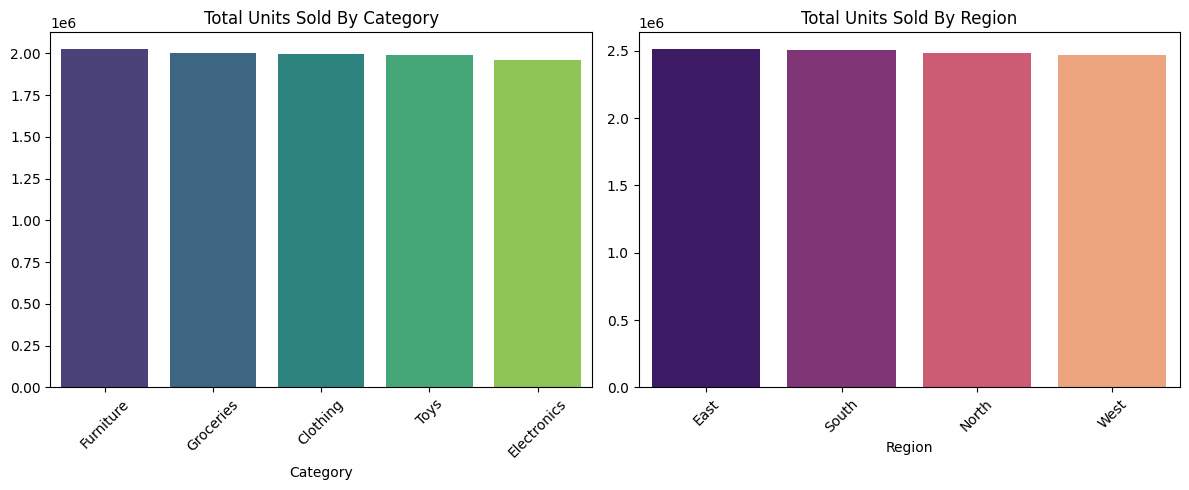

In [3]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

category_sales = df.groupby('Category')['Units Sold'].sum().sort_values(ascending=False)
region_sales = df.groupby('Region')['Units Sold'].sum().sort_values(ascending=False)

#visualization according to Category and Region
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x=category_sales.index, y=category_sales.values, palette='viridis')
plt.title('Total Units Sold By Category')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(x=region_sales.index, y=region_sales.values, palette='magma')
plt.title('Total Units Sold By Region')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('category_region_sales.png')

Features selected: ['Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing', 'Month', 'DayOfWeek', 'Year', 'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys', 'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']


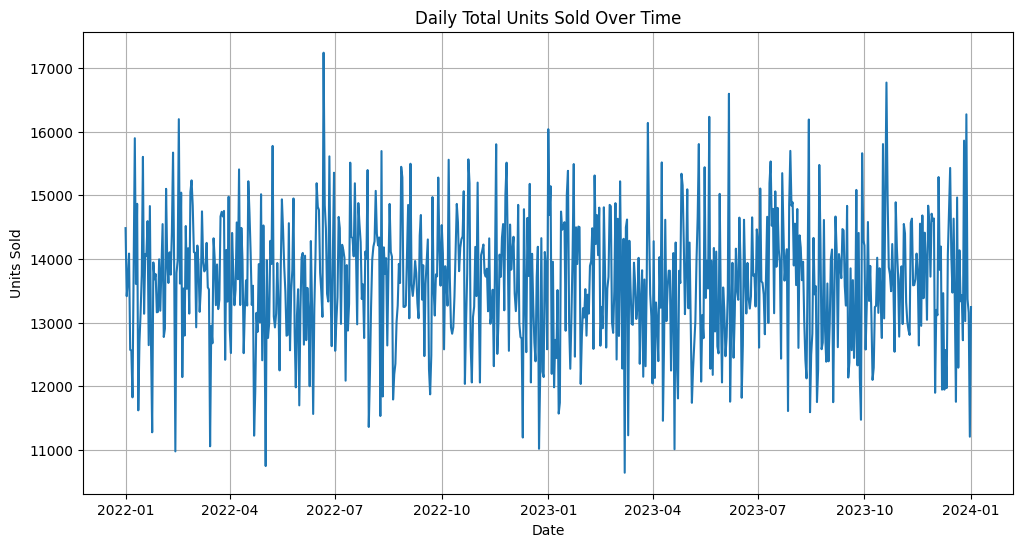

In [5]:
# Visualization 2: Time Trend
time_trend = df.groupby('Date')['Units Sold'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_trend, x='Date', y='Units Sold')
plt.title('Daily Total Units Sold Over Time')
plt.grid(True)
plt.savefig('sales_trend.png')

# Prep for Modeling: Feature Engineering
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Year'] = df['Date'].dt.year

# One-hot encoding for categorical variables
cat_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Select features
# Dropping Store ID, Product ID, Date for the basic model, but in a real TS model these are key.
features = ['Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 
            'Holiday/Promotion', 'Competitor Pricing', 'Month', 'DayOfWeek', 'Year'] + \
           [col for col in df_encoded.columns if any(cat in col for cat in cat_cols)]

X = df_encoded[features]
y = df_encoded['Units Sold']

print("Features selected:", features)

Train set size: (58480, 23), Test set size: (14620, 23)
RMSE: 8.6111
R2 Score: 0.9937
Training Time: 99.56 seconds


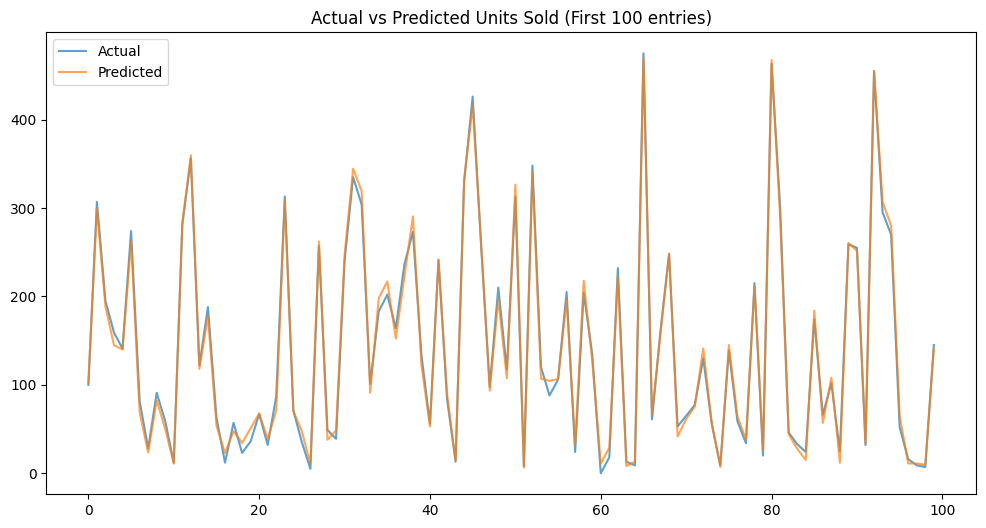

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

# Time Series Split: Sort by date
df_sorted = df_encoded.sort_values('Date')

# Define target and features
y = df_sorted['Units Sold']
X = df_sorted[features]

# Split into 80% train and 20% test (chronological)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")

# Model Training (Random Forest)
start_time = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
end_time = time.time()

# Model Selection: We chose Random Forest due to its ability to handle non-linearity and tabular features effectively.

# Prediction
y_pred = rf_model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Visualization 4: Actual vs Predicted (Sample for clarity)
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Units Sold (First 100 entries)')
plt.legend()
plt.savefig('actual_vs_predicted.png')